# Bayes regression

Now that we have trials.csv, we want to run a bayesian regression that will tell us which hyperparameters are the most useful for improving the model.

In [1]:
import pandas as pd

trial_df = pd.read_csv('../data/trials.csv')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lemmatization_effect, stopword_removal_effect, stemming_effect, treebank_pos_effect, n_grams_effect, classifier_type_effect, vocab_limit_effect, Intercept, sigma]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 281 seconds.


                           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
lemmatization_effect      -0.03  0.02   -0.06     0.01       0.00      0.0   
stopword_removal_effect   -0.28  0.02   -0.32    -0.24       0.00      0.0   
stemming_effect           -0.18  0.02   -0.21    -0.14       0.00      0.0   
treebank_pos_effect        0.04  0.02    0.01     0.08       0.00      0.0   
n_grams_effect[0]          0.53  0.42   -0.26     1.34       0.01      0.0   
n_grams_effect[1]          0.54  0.42   -0.26     1.33       0.01      0.0   
n_grams_effect[2]          0.46  0.42   -0.33     1.26       0.01      0.0   
n_grams_effect[3]          0.65  0.42   -0.14     1.45       0.01      0.0   
n_grams_effect[4]          0.54  0.42   -0.29     1.31       0.01      0.0   
classifier_type_effect[0]  1.27  0.46    0.43     2.13       0.01      0.0   
classifier_type_effect[1] -0.62  0.45   -1.48     0.21       0.01      0.0   
classifier_type_effect[2]  0.81  0.45   -0.05     1.65       0.0

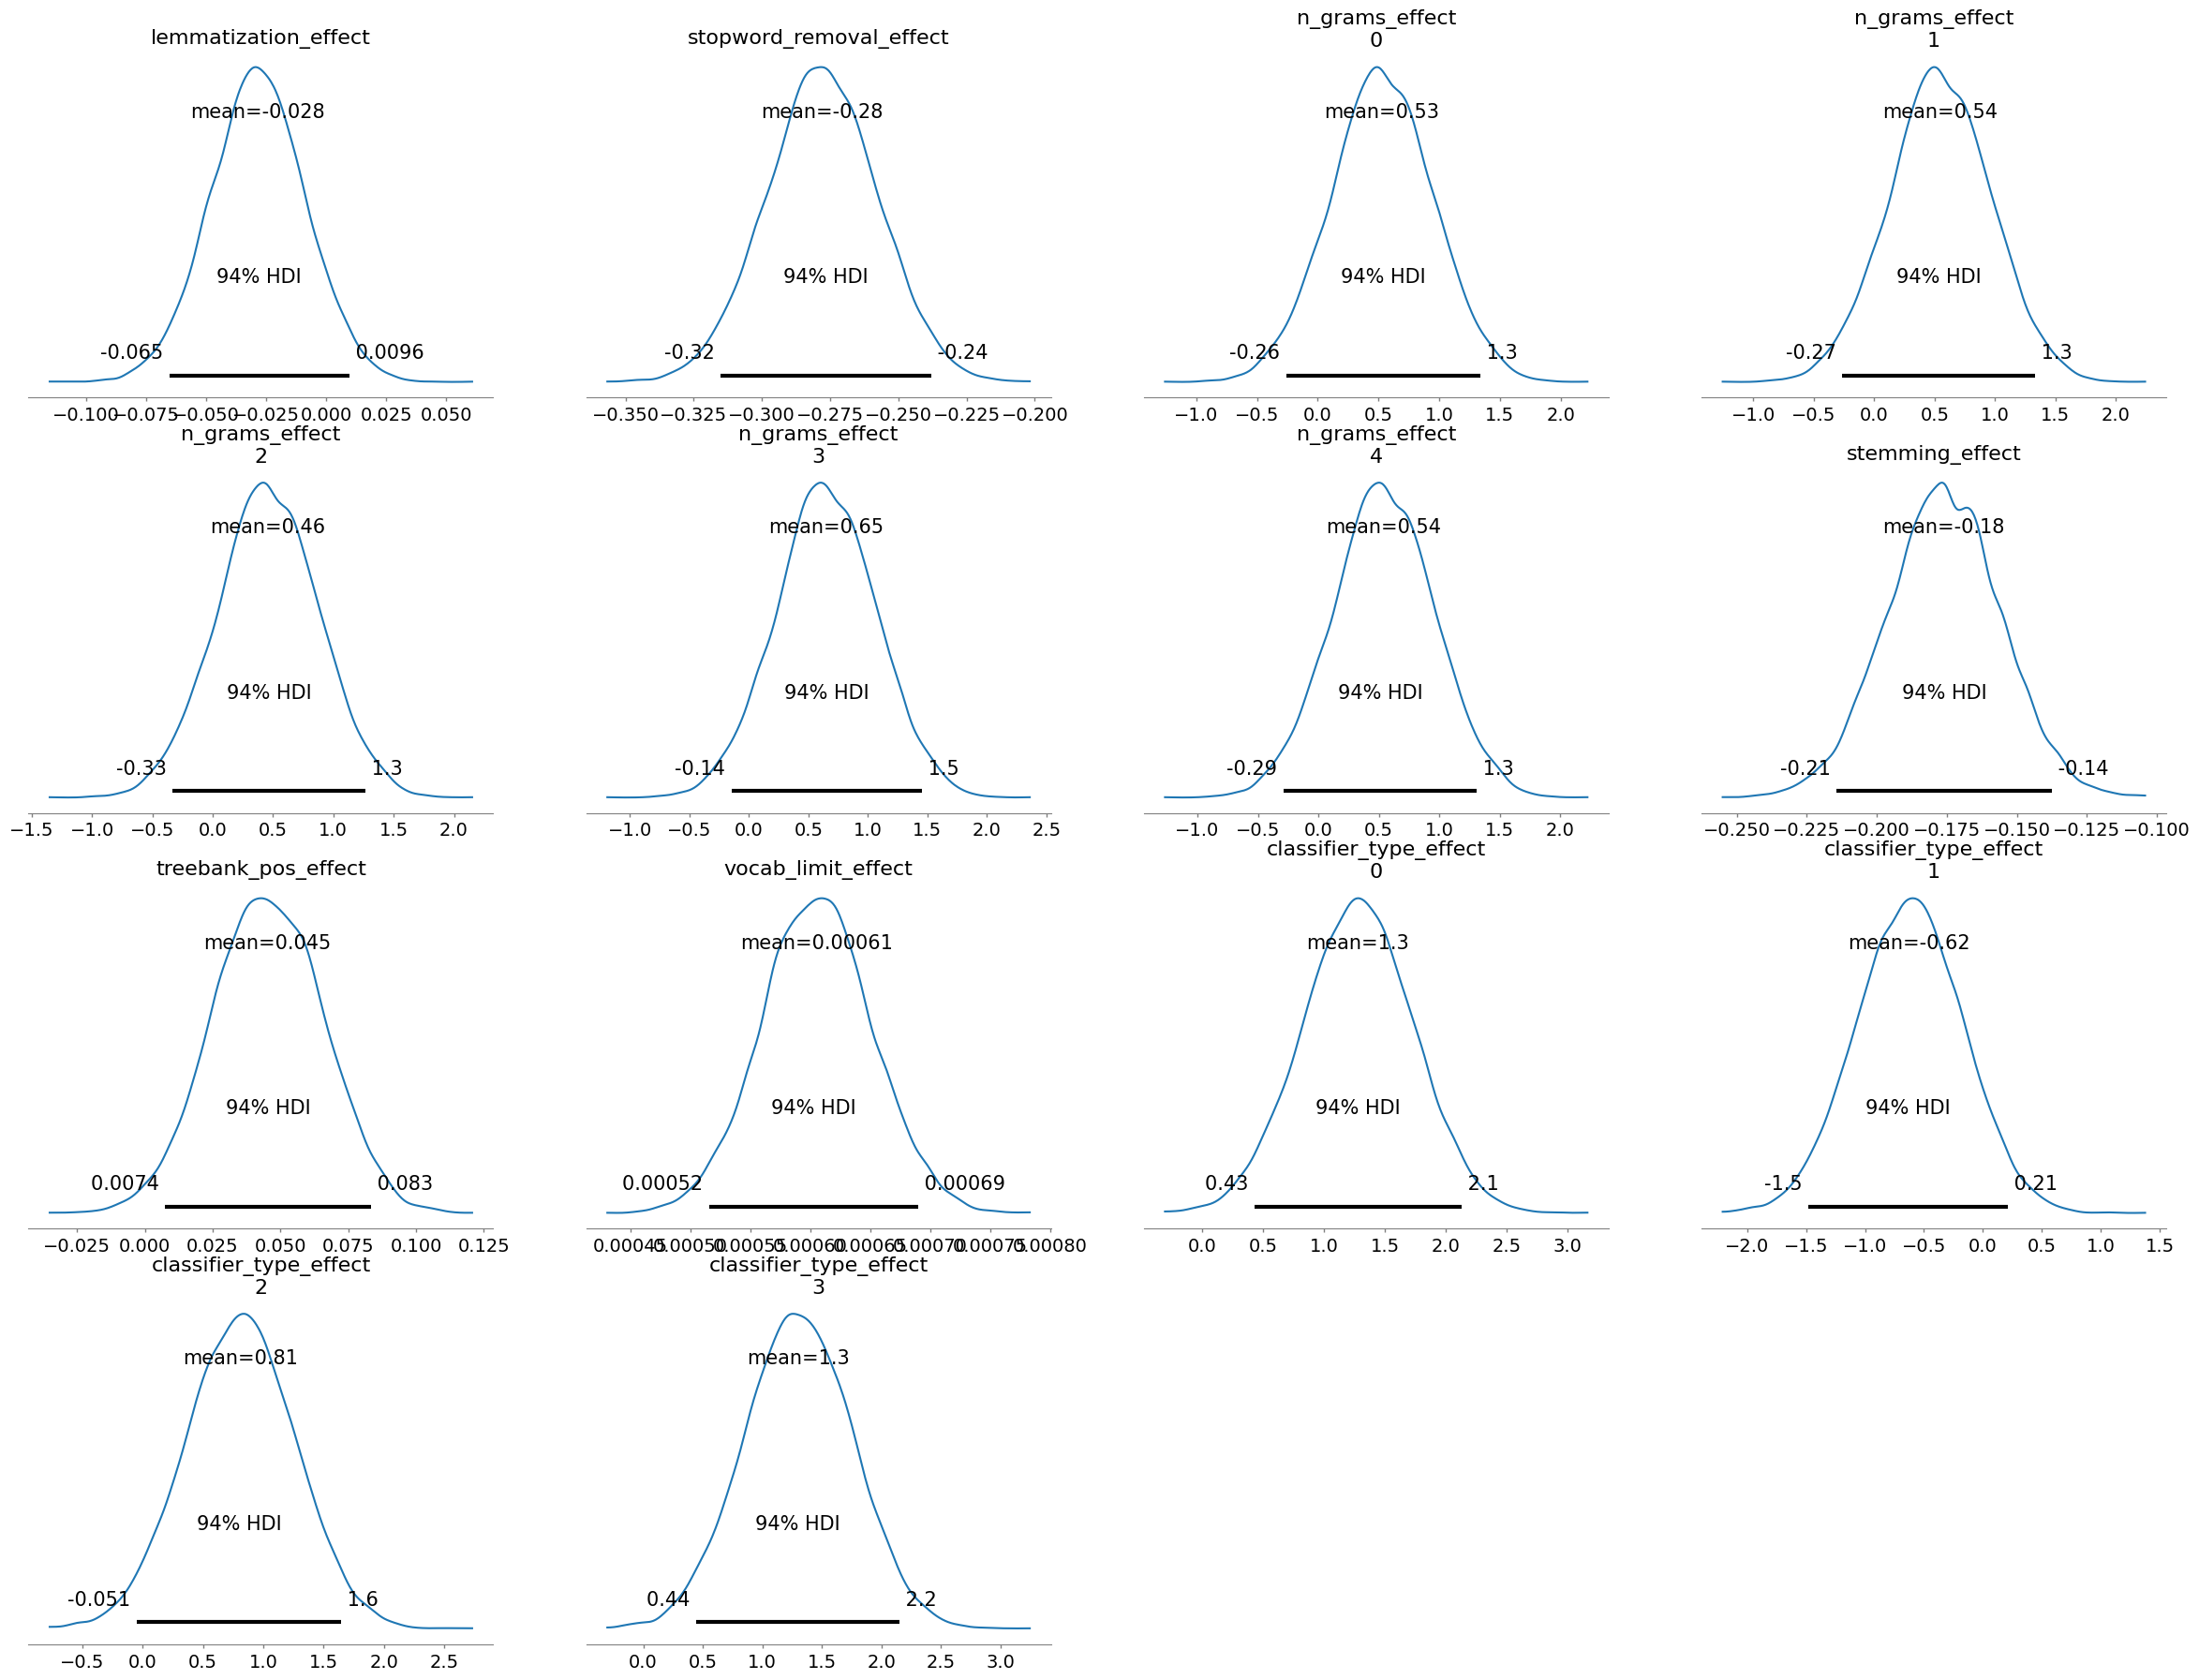

In [2]:
import pymc as pm
import numpy as np
import pandas as pd

# One-hot encode the n-grams
n_grams_onehot = pd.get_dummies(trial_df['n-grams']).values
# One-hot encode the classifier type
classifier_type_onehot = pd.get_dummies(trial_df['classifier_type']).values

with pm.Model() as hyperparam_model:
    # Normal priors for the binary hyperparameters
    lemmatization_effect = pm.Normal('lemmatization_effect', 0, 1)
    stopword_removal_effect = pm.Normal('stopword_removal_effect', 0, 1)
    stemming_effect = pm.Normal('stemming_effect', 0, 1)
    treebank_pos_effect = pm.Normal('treebank_pos_effect', 0, 1)
    
    # Categorical prior for n-grams
    n_grams_effect = pm.Normal('n_grams_effect', 0, 1, shape=5)  # one effect per category
    
    # Categorical prior for classifier type
    classifier_type_effect = pm.Normal('classifier_type_effect', 0, 1, shape=4)  # one effect per classifier type
    
    # Normal prior for vocab_limit's effect
    vocab_limit_effect = pm.Normal('vocab_limit_effect', 0, 1)
    
    # The linear model for accuracy
    intercept = pm.Normal('Intercept', mu=0, sigma=1)
    
    # Expected mu for the linear model
    mu = pm.invlogit(intercept + 
                     lemmatization_effect * trial_df['lemmatization'] + 
                     stopword_removal_effect * trial_df['stopword_removal'] +
                     pm.math.dot(n_grams_onehot, n_grams_effect) +
                     pm.math.dot(classifier_type_onehot, classifier_type_effect) + # added this line for classifier type
                     stemming_effect * trial_df['stemming'] +
                     treebank_pos_effect * trial_df['treebank_pos'] +
                     vocab_limit_effect * trial_df['vocab_limit'])
    
    sigma = pm.HalfNormal('sigma', sigma=0.01)
    observed_accuracy = pm.Normal('observed_accuracy', mu=mu, sigma=sigma, observed=trial_df['accuracy'])
    
    # Sample from the posterior
    trace = pm.sample(4000, tune=2000, chains=4)

# Display the summary
print(pm.summary(trace).round(2))

# Visualization
pm.plot_posterior(trace, var_names=['lemmatization_effect', 'stopword_removal_effect', 'n_grams_effect', 'stemming_effect', 'treebank_pos_effect', 'vocab_limit_effect', 'classifier_type_effect']);  # added classifier_type_effect to visualization


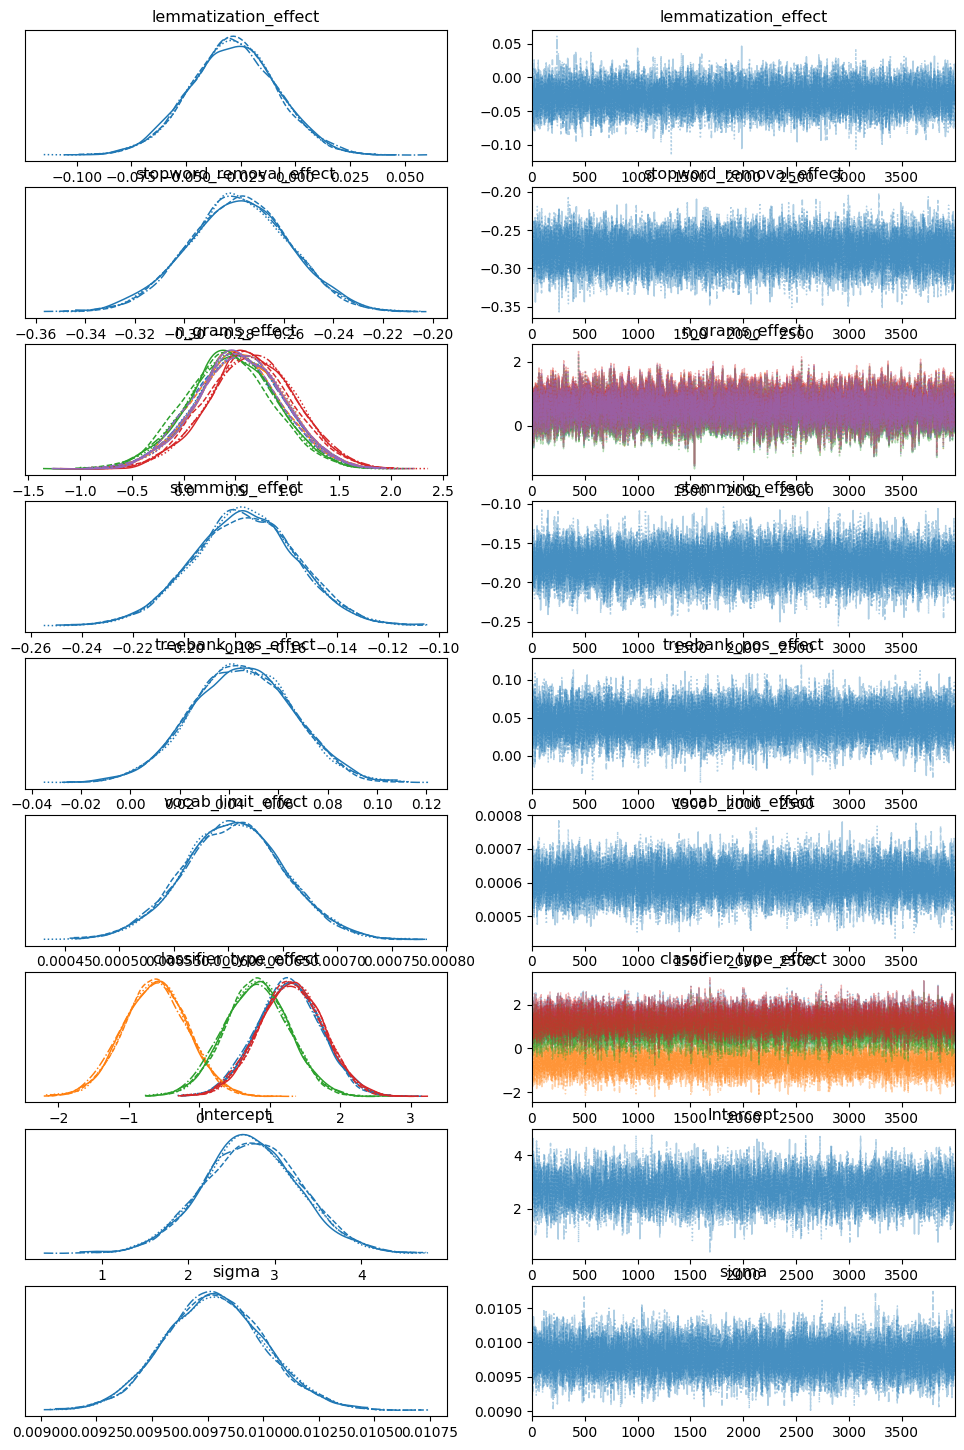

In [3]:
pm.plot_trace(trace, var_names=['lemmatization_effect', 'stopword_removal_effect', 'n_grams_effect', 'stemming_effect', 'treebank_pos_effect', 'vocab_limit_effect', 'classifier_type_effect', 'Intercept', 'sigma']);

In [4]:
from scipy.special import logit, expit

print(pm.summary(trace)[['mean', 'hdi_3%', 'hdi_97%']].map(expit))

                               mean    hdi_3%   hdi_97%
lemmatization_effect       0.493000  0.483756  0.502500
stopword_removal_effect    0.430944  0.421895  0.440779
stemming_effect            0.456113  0.446703  0.465803
treebank_pos_effect        0.511248  0.501750  0.520738
n_grams_effect[0]          0.629017  0.436101  0.792654
n_grams_effect[1]          0.632045  0.434135  0.791006
n_grams_effect[2]          0.612065  0.418241  0.779714
n_grams_effect[3]          0.657010  0.463813  0.810152
n_grams_effect[4]          0.631114  0.428249  0.787346
classifier_type_effect[0]  0.781427  0.605157  0.894069
classifier_type_effect[1]  0.348645  0.185579  0.553050
classifier_type_effect[2]  0.691896  0.487253  0.838350
classifier_type_effect[3]  0.786171  0.609450  0.896228
vocab_limit_effect         0.500250  0.500250  0.500250
Intercept                  0.938544  0.842905  0.978076
sigma                      0.502500  0.502250  0.502500


In [5]:
import pandas as pd
from scipy.special import expit

# Define the function for computing average contribution
def average_contribution(parameter_values, parameter_name):
    baseline_prediction = expit(parameter_values['Intercept'])
    prediction_with_param_zeroed = expit(parameter_values['Intercept'] - parameter_values[parameter_name])
    return baseline_prediction - prediction_with_param_zeroed

# Extract mean, 3% and 97% values of parameters
summary_df = pm.summary(trace)
parameter_stats = {
    'mean': summary_df['mean'],
    'hdi_3%': summary_df['hdi_3%'],
    'hdi_97%': summary_df['hdi_97%']
}

# Compute the average contribution for each parameter at each statistic (mean, 3%, 97%)
parameters = ['lemmatization_effect', 'stopword_removal_effect', 'stemming_effect', 'treebank_pos_effect', 
              'n_grams_effect[0]', 'n_grams_effect[1]', 'n_grams_effect[2]', 'n_grams_effect[3]', 'n_grams_effect[4]', 
              'classifier_type_effect[0]', 'classifier_type_effect[1]', 'classifier_type_effect[2]', 'classifier_type_effect[3]', 
              'vocab_limit_effect']

contributions = {}
for stat, values in parameter_stats.items():
    contributions_stat = {}
    for param in parameters:
        contributions_stat[param] = average_contribution(values, param)
    contributions[stat] = contributions_stat

# Format contributions as DataFrame
df_contributions = pd.DataFrame(contributions)

# Update classifier names based on mapping
classifier_mapping = {
    'classifier_type_effect[0]': "sgd",
    'classifier_type_effect[1]': "logistic",
    'classifier_type_effect[2]': "svm",
    'classifier_type_effect[3]': "naive_bayes"
}

# Replace the index names
df_contributions = df_contributions.rename(index=classifier_mapping)
df_contributions.index = df_contributions.index.str.replace('_effect', '')

# Update n_grams names
ngrams_mapping = {
    'n_grams[0]': 'ngrams=1',
    'n_grams[1]': 'ngrams=2',
    'n_grams[2]': 'ngrams=3',
    'n_grams[3]': 'ngrams=4',
    'n_grams[4]': 'ngrams=5'
}
df_contributions = df_contributions.rename(index=ngrams_mapping)

# Round to 4 significant figures
df_contributions = df_contributions.round(4)

# Determine effect direction and significance
df_contributions['Effect Direction'] = df_contributions['mean'].apply(lambda x: 'positive' if x > 0 else 'negative')
df_contributions['Significance'] = df_contributions.apply(lambda row: 'significant' if (row['hdi_3%'] > 0 and row['hdi_97%'] > 0) or (row['hdi_3%'] < 0 and row['hdi_97%'] < 0) else 'insignificant', axis=1)

# Display the DataFrame
df_contributions.sort_values('mean', ascending=False)

,mean,hdi_3%,hdi_97%,Effect Direction,Significance
naive_bayes,0.1326,0.0682,0.1403,positive,significant
sgd,0.1282,0.0651,0.1372,positive,significant
svm,0.0667,-0.0066,0.0822,positive,insignificant
ngrams=4,0.0500,-0.0183,0.0654,positive,insignificant
ngrams=2,0.0396,-0.0320,0.0563,positive,insignificant
ngrams=5,0.0393,-0.0346,0.0547,positive,insignificant
ngrams=1,0.0385,-0.0311,0.0570,positive,insignificant
ngrams=3,0.0322,-0.0389,0.0516,positive,insignificant
treebank_pos,0.0026,0.0009,0.0019,positive,significant
vocab_limit,0.0001,0.0001,0.0000,positive,insignificant


In [6]:
df_contributions[df_contributions.Significance == 'significant'].sort_values('mean', ascending=False)

,mean,hdi_3%,hdi_97%,Effect Direction,Significance
naive_bayes,0.1326,0.0682,0.1403,positive,significant
sgd,0.1282,0.0651,0.1372,positive,significant
treebank_pos,0.0026,0.0009,0.0019,positive,significant
stemming,-0.0094,-0.0263,-0.0028,negative,significant
stopword_removal,-0.0142,-0.0374,-0.0046,negative,significant
